# 主要目标
尝试使用神经网络直接拟合策略网络的输出。而不是使用TD的方案。
主要是提升对于这个“蒙特卡洛是步长最大的多步TD”的理解。

In [10]:
# import everything here...
%load_ext autoreload
%autoreload 2
from RL_utils import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# create env
import gym
env = gym.make("CartPole-v0")
config = Config(learning_rate=0.001, DBM=True) # 使用默认配置
if config.DBM:
    config.print_cfg()
    env = gym.make("CartPole-v1",render_mode="human")
set_seed(config)

--- config ---
max_episode: 1000
max_steps: 100
learning_rate: 0.1
gamma: 0.99
epsilon: 0.1
seed: 42
tau: 0.01
------------


e:\anaconda\envs\llama_factory\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [12]:
# network construction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config.DBM:
    print("using device:",device)
env_cfg = Env_Config(obdim=env.observation_space.shape[0],acdim=env.action_space.n)
if config.DBM:
    env_cfg.print_cfg()
epsilon = Epsilon(original_val=1, min_val=0.1, liner_decay=1/500)
monte = MonteCarlo(env_config=env_cfg,config=config,device = device)

using device: cuda
obdim: 4
acdim: 2


KeyboardInterrupt: 

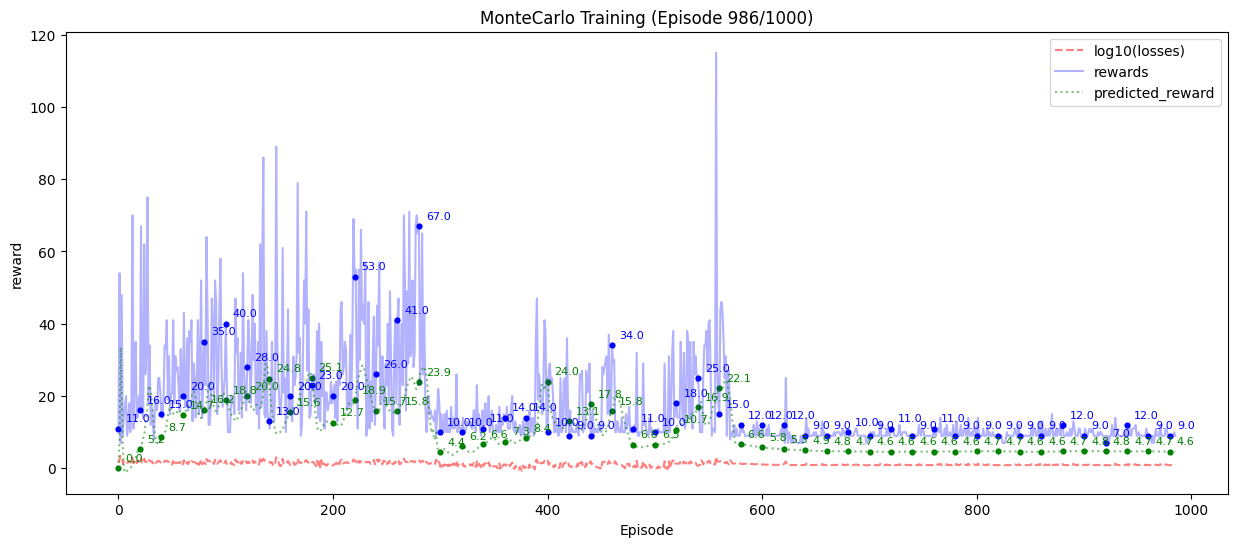

In [13]:
log = defaultdict(list)
for episode_num in range(config.max_episode):
    episode_reward_list = [] # 一个episode的各个步的reward
    episode_state_list = []
    episode_action_list = []
    state, _ = env.reset(seed = config.seed)
    done = False
    # 更新之前先评估一下当前预测的return，看是低估了还是高估了
    predict_total_reward = monte.model(torch.from_numpy(state).to(device=device))
    log["predicted_total_reward"].append(torch.mean(predict_total_reward).item())
    while not done:
        action = select_action(state=state, env = env, model = monte.model, epsilon = epsilon, config=config,device=device, update_epsilon=False)
        next_state, reward, done, _, info = env.step(action=action)
        if done:
            reward = 0
        episode_reward_list.append(reward)
        episode_state_list.append(state)
        episode_action_list.append(action)
        if config.DBM:
            print_(reward)
            print_(state)
        state = next_state
    loss = monte.update(episode_reward_list=episode_reward_list,episode_state_list=episode_state_list,episode_action_list=episode_action_list)
    log["total_reward"].append(sum(episode_reward_list))
    log["total_loss"].append(np.log10(loss))
    # draw in ipynb
    draw_in_ipynb(x_s=[None,None,None],y_s=[log["total_loss"],log["total_reward"],log['predicted_total_reward']],alpha_s=[0.5,0.3,0.5],label_s=["log10(losses)","rewards",'predicted_reward'],mark_s=["r--",'b-',"g:"],subject="MonteCarlo",config=config)
    epsilon.lin_update()